In [ ]:
import pandas
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive, files
import tensorflow as tf
#from tensorflow import keras

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 9.1MB/s 


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Kaggle'

kaggle.json


In [ ]:
with open('/content/drive/My Drive/Kaggle/kaggle.json') as f:
  auth = json.load(f)
  user = auth["username"]
  key = auth["key"]

In [ ]:
os.environ['KAGGLE_USERNAME'] = user
os.environ['KAGGLE_KEY'] = key

In [ ]:
!kaggle datasets download -d drscarlat/melanoma -p '/content/MyDrive/melanoma'

100% 5.26G/5.26G [01:50<00:00, 29.8MB/s]



In [ ]:
%cd /content/MyDrive/melanoma
!unzip 'melanoma.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031354.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031355.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031357.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031358.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031362.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031363.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031365.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031366.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031367.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031370.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031375.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031380.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031382.jpg  
  inflating: dermmel/DermMel/train_sep/

In [ ]:
!ls '/content/MyDrive/melanoma/DermMel/'

test  train_sep  valid


In [ ]:
%cd /content/MyDrive/melanoma/DermMel

/content/MyDrive/melanoma/DermMel


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
minibatch_size = 64
pic_size = 100
data_train = ImageDataGenerator(rescale = 1.0/255.0)
data_valid = ImageDataGenerator(rescale = 1.0/255.0)
data_test = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
train_generator = data_train.flow_from_directory('train_sep/', 
                                                 color_mode = 'rgb',
                                                 batch_size = minibatch_size,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

validation_generator = data_valid.flow_from_directory('valid/', 
                                                 color_mode = 'rgb',
                                                 batch_size = minibatch_size,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

test_generator = data_test.flow_from_directory('test/', 
                                                 color_mode = 'rgb',
                                                 batch_size = 1,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


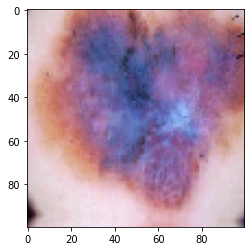

In [ ]:
plt.imshow(train_generator[0][0][9])
plt.show()

In [ ]:
input_shape_dim = train_generator[0][0].shape
input_shape_dim[1:] 

(100, 100, 3)

In [ ]:
validation_generator[0][0].shape

(64, 100, 100, 3)

In [ ]:
test_generator[0][1].size

2

In [ ]:
def build_model(hp):
  inputs = tf.keras.Input(shape=input_shape_dim[1:])
  x = inputs
  for i in range(hp.Int('conv_blocks', 1, 3, default=2)):
    filters = hp.Int('filters_' + str(i), 32, 256, step=32)
    for _ in range(2):
      x = tf.keras.layers.Conv2D(
        filters, kernel_size=(3, 3))(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    else:
      x = tf.keras.layers.AvgPool2D(pool_size = (2, 2))(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  for j in range(hp.Int('n_layers', 1, 3)):
    x = tf.keras.layers.Dense(
        hp.Int('hidden_size', 30, 100, step=10, default=50),
        activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(
        hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(test_generator[0][1].size, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-04),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [ ]:
# def build_model(hp):
#   inputs = tf.keras.Input(shape=input_shape_dim[1:])
#   x = inputs
#   for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
#     filters = hp.Int('filters_' + str(i), 32, 256, step=32)
#     for _ in range(2):
#       x = tf.keras.layers.Convolution2D(
#         filters, kernel_size=(3, 3), padding='same')(x)
#       x = tf.keras.layers.BatchNormalization()(x)
#       x = tf.keras.layers.ReLU()(x)
#     if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
#       x = tf.keras.layers.MaxPool2D()(x)
#     else:
#       x = tf.keras.layers.AvgPool2D()(x)
#   x = tf.keras.layers.GlobalAvgPool2D()(x)
#   x = tf.keras.layers.Dense(
#       hp.Int('hidden_size', 30, 100, step=10, default=50),
#       activation='relu')(x)
#   x = tf.keras.layers.Dropout(
#       hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
#   outputs = tf.keras.layers.Dense(test_generator[0][1].size, activation='softmax')(x)
#   model = tf.keras.Model(inputs, outputs)
#   model.compile(
#     optimizer=tf.keras.optimizers.Adam(
#       hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
#     loss='categorical_crossentropy', 
#     metrics=['accuracy'])
#   return model

In [ ]:
import kerastuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    hyperband_iterations=2)

In [ ]:
checkpoint = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", verbose = 1, mode = 'max', patience=1)
callbacks_list = [checkpoint]

In [ ]:
EPOCHS = 20

In [ ]:
tuner.search(train_generator,
             steps_per_epoch=train_generator.n // train_generator.batch_size, 
             epochs=EPOCHS, 
             validation_data=validation_generator,
             validation_steps=validation_generator.n //  validation_generator.batch_size,
             callbacks=[callbacks_list])

Trial 55 Complete [00h 02m 38s]
val_accuracy: 0.5278409123420715

Best val_accuracy So Far: 0.8903409242630005
Total elapsed time: 04h 06m 56s

Search: Running Trial #56

Hyperparameter    |Value             |Best Value So Far 
conv_blocks       |3                 |2                 
filters_0         |160               |96                
pooling_0         |avg               |max               
filters_1         |64                |32                
pooling_1         |max               |max               
n_layers          |2                 |3                 
hidden_size       |50                |100               
dropout           |0                 |0.2               
filters_2         |224               |256               
pooling_2         |avg               |max               
tuner/epochs      |20                |7                 
tuner/initial_e...|7                 |0                 
tuner/bracket     |1                 |1                 
tuner/round       |1           

In [ ]:
model = tuner.get_best_models(1)[0]

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters

In [ ]:
model.summary()

In [ ]:
model.evaluate(test_generator, steps = test_generator.n//test_generator.batch_size )

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [ ]:
files.download("model.h5")
files.download("model.json")

In [ ]:
# To load the model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [ ]:
model=tf.keras.Sequential()

In [ ]:
EPOCHS = 15
history = model.fit(train_generator, steps_per_epoch=train_generator.n // train_generator.batch_size, 
                    epochs = EPOCHS, 
                    validation_data = validation_generator, 
                    validation_steps= validation_generator.n //  validation_generator.batch_size,
                    callbacks= callbacks_list)